In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
warnings.filterwarnings(action='once')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
#tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [136]:
grouped_raw_data = {}
success = []
failed = []
body_part ='tail_base'
numbins_per_mouse = 150

for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        interpolated['by_mouse_vbins'] = pd.cut(interpolated[body_part], bins=50)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        # downsample and bin
        #cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(binning_time, number_of_bins, body_part_for_tracking, interpolated, C_z_scored)

        #group_results_binning[tracking_file.split('/')[-2]] = {'C_z_scored':C_z_scored, 'tracking_data' :interpolated, 
        #                                      'C_binned_by_V':cells_C_binned_by_V, 'C_binned_by_V_means':cells_mean_C_binned_by_V}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
        #load spatial components by session
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## regressions across cells

In [137]:
## interval range for velocity binning
binning_range = pd.interval_range(start=-1, end=150)

In [138]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = 2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=binning_range)

V_df['velocity_bins'] = all_sessions_v_bins

In [139]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
C_df['velocity_bins'] = all_sessions_v_bins
C_df['by_mouse_vbins'] = V_df['by_mouse_vbins']

In [140]:
#C_df

In [141]:
# bin values
all_sessions_v_bins.values.categories.values

<IntervalArray>
[(-1, 0], (0, 1], (1, 2], (2, 3], (3, 4] ... (145, 146], (146, 147], (147, 148], (148, 149], (149, 150]]
Length: 151, closed: right, dtype: interval[int64]

In [167]:
# get regions where velocity is in bin 
by_cells_across_sessions = {}
for session in list(grouped_raw_data.keys()):
    binned_regions = [C_df.loc[session][C_df.loc[session]['velocity_bins']==v_bin].drop(['velocity_bins', 'by_mouse_vbins'], axis=1).mean(axis=0).dropna() for
                  v_bin in all_sessions_v_bins.values.categories.values]
    cells_by_session_binned = pd.DataFrame(binned_regions, index=all_sessions_v_bins.values.categories.values).drop(['msCamFrame'], axis=1)
    per_cell_regressions = dlc_utils.create_regression_models_per_cell(cells_by_session_binned, 2)
    by_cells_across_sessions[session] = per_cell_regressions

In [143]:
# get regions where velocity is in bin, by each recording session 
by_cells_across_sessions_session_bins = {}
for session in list(grouped_raw_data.keys()):
    binned_regions_each_session = [C_df.loc[session][C_df.loc[session]['by_mouse_vbins']==bin_].drop(['velocity_bins', 'by_mouse_vbins'], axis=1).mean(axis=0).dropna() for
                  bin_ in pd.cut(grouped_raw_data[session]['interpolated'][body_part], bins=50).values.categories.values]
    cells_by_session_binned_each_session = pd.DataFrame(binned_regions_each_session, index=pd.cut(grouped_raw_data[session]['interpolated'][body_part], bins=50).values.categories.values)
    per_cell_regressions_each_session = dlc_utils.create_regression_models_per_cell(cells_by_session_binned_each_session, 2)
    by_cells_across_sessions_session_bins[session] = per_cell_regressions_each_session

In [149]:
#list(grouped_raw_data.keys())

In [191]:
#get the velocity bin where cell fired most
max_bins = []
for session in list(grouped_raw_data.keys()):
    for cell in list(by_cells_across_sessions[session].keys()):
        max_bins.append(pd.DataFrame({(session,cell): by_cells_across_sessions[session][cell]['fit_df'].iloc[by_cells_across_sessions[session][cell]['fit_df']['y'].argmax()]}))
        #max_bins.append(by_cells_across_sessions[session][cell]['fit_df'].max(axis=0))

max_bins = pd.concat(max_bins, axis=1)

In [196]:
#get the velocity bin where cell fired most
max_bins_relative_bins = []
for session in list(grouped_raw_data.keys()):
    for cell in list(by_cells_across_sessions_session_bins[session].keys()):
        max_bins_relative_bins.append(pd.DataFrame({(session, cell): by_cells_across_sessions_session_bins[session][cell]['fit_df'].iloc[by_cells_across_sessions_session_bins[session][cell]['fit_df']['y'].argmax()]}))
        #max_bins.append(by_cells_across_sessions[session][cell]['fit_df'].max(axis=0))

max_bins_relative_bins = pd.concat(max_bins_relative_bins, axis=1)

In [222]:
max_bins.to_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_wt.csv')
max_bins_relative_bins.to_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_rel_wt.csv')

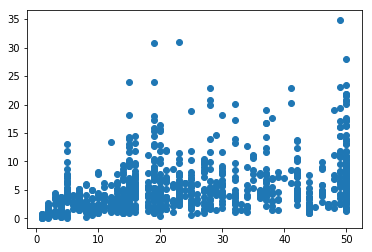

In [197]:
# distribution of all df versus velocity values 
plt.scatter(max_bins_relative_bins.loc['x'].values, max_bins_relative_bins.loc['y'].values)
plt.show()

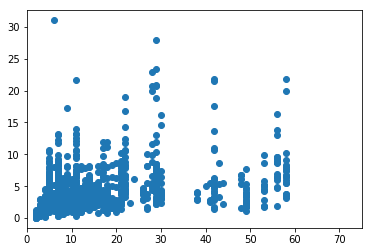

In [292]:
# distribution of all df versus velocity values 
plt.scatter(max_bins.loc['x'].values, max_bins.loc['y'].values)
plt.xlim((0, 75))
plt.show()

In [278]:
# load KO data 
ko_bins = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_ko.csv', index_col=0)
ko_bins_relative = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_rel_ko.csv', index_col=0)

In [285]:
max_v_bins_cumulative = stats.cumfreq(max_bins.loc['x'].values, numbins=150, defaultreallimits=(-1, 150))
max_v_bins_cumulative_relative = stats.cumfreq(max_bins_relative_bins.loc['x'].values, numbins=150, defaultreallimits=(0, 50))
ko_bins_cumulative = stats.cumfreq(ko_bins.loc['x'].values, numbins=150, defaultreallimits=(-1, 150))
ko_bins_cumulative_relative = stats.cumfreq(np.array(ko_bins_relative.loc['x'].values, dtype=np.float64), numbins=150, defaultreallimits=(0, 50)) 

In [286]:
wt_data = max_v_bins_cumulative.cumcount/len(max_bins.loc['x'].values)
wt_data_relative = max_v_bins_cumulative_relative.cumcount/len(max_bins_relative_bins.loc['x'].values)
ko_data = ko_bins_cumulative.cumcount/len(ko_bins.loc['x'].values)
ko_data_relative = ko_bins_cumulative_relative.cumcount/len(ko_bins_relative.loc['x'].values)

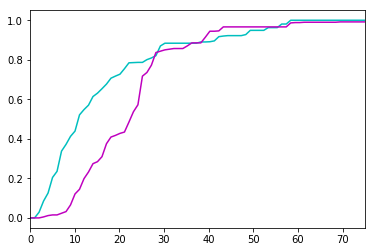

In [293]:
plt.plot(np.linspace(0, 150, 150), wt_data, color='c')
plt.plot(np.linspace(0, 150, 150), ko_data, color='m')
plt.xlim((0, 75))
plt.show()

In [288]:
stats.ks_2samp(wt_data, ko_data)

Ks_2sampResult(statistic=0.5333333333333333, pvalue=7.024721813246e-20)

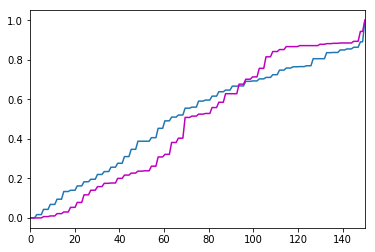

In [289]:
plt.plot(np.linspace(0, 150, 150), wt_data_relative)
plt.plot(np.linspace(0, 150, 150), ko_data_relative, color='m')
plt.xlim((0, 150))
plt.show()

In [290]:
stats.ks_2samp(wt_data_relative, ko_data_relative)

Ks_2sampResult(statistic=0.22, pvalue=0.0013578778610396696)

In [19]:
# get curve for all cells
x = np.linspace(1, 50, 50)
trends_by_cell = {}
for session in list(grouped_raw_data.keys()):
    for cell in (by_cells_across_sessions[session].keys()):
        trends_by_cell[session+'_'+str(cell)] = by_cells_across_sessions[session][cell]['model'](x)
trendlines_by_cell = pd.DataFrame(trends_by_cell)

In [20]:
# get curve for all cells
x = np.linspace(1, 50, 50)
trends_by_cell_significant = {}
for session in list(grouped_raw_data.keys()):
    for cell in (by_cells_across_sessions[session].keys()):
        if float(by_cells_across_sessions[session][cell]['statsmodel_results'].summary().tables[0][3][3].data)<0.5: 
            trends_by_cell_significant[session+'_'+str(cell)] = by_cells_across_sessions[session][cell]['model'](x)
trendlines_by_cell_significant = pd.DataFrame(trends_by_cell_significant)

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/j

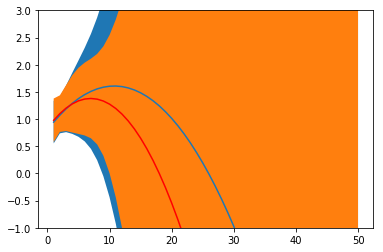

In [28]:
#maybe do analyze per animal by then group by range across all at end 
plt.plot(x, trendlines_by_cell.mean(axis=1))
mean = trendlines_by_cell.mean(axis=1)
std_error = (trendlines_by_cell.std(axis=1)/math.sqrt(4))
plt.fill_between(x, mean-std_error, mean+std_error)
plt.plot(x, trendlines_by_cell_significant.mean(axis=1), color='r')
mean_2 = trendlines_by_cell_significant.mean(axis=1)
std_error_2 = (trendlines_by_cell_significant.std(axis=1)/math.sqrt(4))
plt.fill_between(x, mean_2-std_error_2, mean_2+std_error_2)
plt.ylim([-1, 3])
plt.show()